# Memento-CXG cross-dataset showcase

In [257]:
import tiledb
import tiledbsoma as soma
from somacore import ExperimentAxisQuery, AxisQuery
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import itertools
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import scanpy as sc
import statsmodels.api as sm
pd.set_option('display.max_rows', 500)

In [258]:
from statsmodels.stats.multitest import fdrcorrection

In [259]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento

In [260]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

In [261]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [262]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/Data/mementocxg/'

### Identify datasets

Pick datasets with a few donors, see if combining datasets improve power.

In [ ]:
dataset_ids_to_query = ['c7775e88-49bf-4ba2-a03b-93f00447c958', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '4c4cd77c-8fee-4836-9145-16562a8782fe']
dataset_query = '('
for idx, di in enumerate(dataset_ids_to_query): 
    dataset_query += f'dataset_id == "{di}" '
    if idx != len(dataset_ids_to_query)-1:
        dataset_query += 'or '
dataset_query += ')'

celltypes_to_query = [
    'conventional dendritic cell',
    'plasmacytoid dendritic cell',
    'conventional dendritic cell',
    'plasmacytoid dendritic cell, human',
    'dendritic cell',
    'dendritic cell, human',
    'myeloid dendritic cell',
    'plasmacytoid dendritic cell']
celltype_query = '('
for idx, ct in enumerate(celltypes_to_query): 
    celltype_query += f'cell_type == "{ct}" '
    if idx != len(celltypes_to_query)-1:
        celltype_query += 'or '
celltype_query += ')'

OBS_VALUE_FILTER_1 = dataset_query # All cells in three datasets
OBS_VALUE_FILTER_2 = celltype_query + ' and ' + celltype_query # only relevant celltypes

exp_uri = 's3://cellxgene-data-public/cell-census/2023-10-30/soma/census_data/homo_sapiens'
layer = "raw"
measurement_name = "RNA"

with soma.Experiment.open(uri=exp_uri,
                          context=soma.SOMATileDBContext().replace(tiledb_config={
                              "vfs.s3.region":"us-west-2",
                              "vfs.s3.no_sign_request":True})
                          ) as exp:

    query = exp.axis_query(measurement_name=measurement_name,
                           obs_query=AxisQuery(value_filter=OBS_VALUE_FILTER_2),
                           # Note: Must use *all* genes to compute size factors correctly, even when var filter is
                           # being used for testing
                           var_query=AxisQuery())
obs_df = query.obs().concat().to_pandas()

In [264]:
cell_counts = obs_df.groupby(['dataset_id', 'donor_id']).size().reset_index(name='count')

In [265]:
donor_counts = cell_counts.groupby('dataset_id').donor_id.size().sort_values()
relevant_datasets = donor_counts[(donor_counts >= 5) & (donor_counts < 10)].index.tolist()

### Read results and plot

In [293]:
relevant_datasets = [
    '2672b679-8048-4f5e-9786-f1b196ccfd08',
    '86282760-5099-4c71-8cdd-412dcbbbd0b9',
    '2872f4b0-b171-46e2-abc6-befcf6de6306',
    '644a578d-ffdc-446b-9679-e7ab4c919c13',
    '11ff73e8-d3e4-4445-9309-477a2c5be6f6',
    '4dd00779-7f73-4f50-89bb-e2d3c6b71b18',
    'bd65a70f-b274-4133-b9dd-0d1431b6af34',
    'b07fb54c-d7ad-4995-8bb0-8f3d8611cabe',
    '3f32121d-126b-4e8d-9f69-d86502d2a1b1',
    'a51c6ece-5731-4128-8c1e-5060e80c69e4',
    'd7dcfd8f-2ee7-4385-b9ac-e074c23ed190',
    '2d31c0ca-0233-41ce-bd1a-05aa8404b073',
    '1e5bd3b8-6a0e-4959-8d69-cafed30fe814',
    # 'cd4c96bb-ad66-4e83-ba9e-a7df8790eb12',
    '44882825-0da1-4547-b721-2c6105d4a9d1',
    '4ed927e9-c099-49af-b8ce-a2652d069333',
    '00ff600e-6e2e-4d76-846f-0eec4f0ae417',
    '105c7dad-0468-4628-a5be-2bb42c6a8ae4',
    'c5d88abe-f23a-45fa-a534-788985e93dad',
    # 'ed5d841d-6346-47d4-ab2f-7119ad7e3a35',
    '53d208b0-2cfd-4366-9866-c3c6114081bc',
    '3de0ad6d-4378-4f62-b37b-ec0b75a50d94',
    '574e9f9e-f8b4-41ef-bf19-89a9964fd9c7',
    '1a2e3350-28a8-4f49-b33c-5b67ceb001f6',
    'd3a83885-5198-4b04-8314-b753b66ef9a8']

In [335]:
def draw_qq(df_input, thresh=1000, color='gray'):
    
    df = df_input[df_input[f'pval'] != 1.00].copy()
    df = (df[df[f'coef'].abs() < thresh])
    pvals = df[f'pval'].sort_values().values
    pvals = pvals[np.isfinite(pvals)]
    unif = np.linspace(1e-6, 1, len(pvals))
    # plt.scatter(unif, pvals, s=1)
    plt.scatter(-np.log10(unif), -np.log10(pvals), s=(3 if color=='cyan' else 1), color=color)
    # plt.plot(-np.log10(unif), -np.log10(unif), color='k')



In [336]:
result_fnames = ['rare_ct_whole.csv'] + [f'rare_ct_{d_id}.csv' for d_id in relevant_datasets]
names = ['whole'] + relevant_datasets

In [337]:
all_results = []
common_genes = set()
for name, fname in zip(names, result_fnames):
    
    res = pd.read_csv(save_path + fname).dropna()
    if res.shape[0] == 0:
        continue
    res = res.set_index('feature_id')
    if name == 'whole':
        common_genes = set(res.index)
    else:
        common_genes = common_genes & set(res.index)
    res['dataset'] = name
    all_results.append(res)
    # plt.ylim(-1, 10)
all_results = pd.concat(all_results).dropna().loc[list(common_genes)]

Text(0, 0.5, 'Observed\n-log10(P-value)')

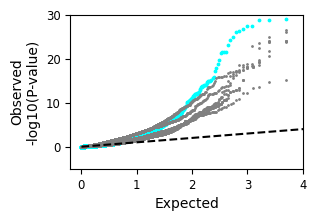

In [338]:
plt.figure(figsize=(3,2))
for name in names:

    draw_qq(all_results.query(f'dataset == "{name}" & pval > 1e-31'), color='cyan' if name == 'whole' else 'gray')


# draw_qq(all_results.query('dataset == "d1"'))
# draw_qq(all_results.query('dataset == "d2"'))
# draw_qq(all_results.query('dataset == "d3"'))
plt.ylim(-5, 30)
plt.xlim(-0.2, 4)
plt.plot([0,8], [0, 8],'--', color='k', );
plt.xlabel('Expected'); plt.ylabel('Observed\n-log10(P-value)')

### Read cube

In [214]:
all_estimators = tiledb.open(cube_path + 'estimators_cube_dcs_many').df[:]\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})

In [86]:
def get_cell_counts():
    
    dataset_ids_to_query = ['c7775e88-49bf-4ba2-a03b-93f00447c958', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '4c4cd77c-8fee-4836-9145-16562a8782fe']
    dataset_query = '('
    for idx, di in enumerate(dataset_ids_to_query): 
        dataset_query += f'dataset_id == "{di}" '
        if idx != len(dataset_ids_to_query)-1:
            dataset_query += 'or '
    dataset_query += ')'

    celltypes_to_query = [
        'conventional dendritic cell',
        'plasmacytoid dendritic cell',
        'conventional dendritic cell',
        'plasmacytoid dendritic cell, human',
        'dendritic cell',
        'dendritic cell, human',
        'myeloid dendritic cell',
        'plasmacytoid dendritic cell']
    celltype_query = '('
    for idx, ct in enumerate(celltypes_to_query): 
        celltype_query += f'cell_type == "{ct}" '
        if idx != len(celltypes_to_query)-1:
            celltype_query += 'or '
    celltype_query += ')'

    OBS_VALUE_FILTER_1 = dataset_query # All cells in three datasets
    OBS_VALUE_FILTER_2 = celltype_query + ' and ' + celltype_query # only relevant celltypes

    exp_uri = 's3://cellxgene-data-public/cell-census/2023-10-30/soma/census_data/homo_sapiens'
    layer = "raw"
    measurement_name = "RNA"

    with soma.Experiment.open(uri=exp_uri,
                              context=soma.SOMATileDBContext().replace(tiledb_config={
                                  "vfs.s3.region":"us-west-2",
                                  "vfs.s3.no_sign_request":True})
                              ) as exp:

        query = exp.axis_query(measurement_name=measurement_name,
                               obs_query=AxisQuery(value_filter=OBS_VALUE_FILTER_2),
                               # Note: Must use *all* genes to compute size factors correctly, even when var filter is
                               # being used for testing
                               var_query=AxisQuery())
    obs_df = query.obs().concat().to_pandas()
    
    cell_count = obs_df.groupby(['cell_type', 'donor_id']).size().reset_index(name='count')
    cell_count['treatment'] = cell_count.apply(treatment_assignment, axis=1)

    names = cell_count[DE_TREATMENT].copy()
    for col in DE_COVARIATES:
        names += '_' + cell_count[col]
    cell_count['group_name'] = names.tolist()
    cell_count = cell_count.drop_duplicates('group_name').set_index('group_name')
    
    return cell_count

    
def get_final_design_matrix(design):
    cov_df = design.iloc[:, 1:]
    cov_df -= cov_df.mean(axis=0)
    stim_df = design.iloc[:, [0]]
    interaction_df = cov_df*stim_df[['treatment']].values
    interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
    cov_df = pd.concat([cov_df, interaction_df], axis=1)
    cov_df = sm.add_constant(cov_df)
    return  pd.concat([stim_df, cov_df], axis=1).values.astype(float)


def wls(X, y, n, v, tau2=0, thresh=1):

    from sklearn.linear_model import LinearRegression
    
    # fit WLS using sample_weights
    WLS = LinearRegression(fit_intercept=False)
    WLS.fit(X, y)
    sample_err = ((WLS.predict(X) - y)**2).mean()
    # print(WLS.coef_)

    coef = WLS.coef_[0]

    # W = np.diag(1/ (v) )
    W = 1/v
    try:
        beta_var_hat = np.diag(np.linalg.pinv((X.T *W)@X ))
    except:
        return coef, np.nan, 0, 0
    # print(beta_var_hat)
    se = np.sqrt( beta_var_hat[0] )
    
    if np.abs(coef) < LFC_THRESHOLD:
        z = 0
        pv = 1
    else:
        z = (np.abs(coef)-LFC_THRESHOLD)/se
        pv = stats.norm.sf(np.abs(z))*2

    return coef, se, z, pv

In [79]:
import tiledb
import tiledbsoma as soma
from somacore import ExperimentAxisQuery, AxisQuery
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import itertools
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import scanpy as sc
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from pymare import meta_regression


CUBE_PATH = '/home/ubuntu/Github/memento-cxg/'
SAVE_PATH = '/home/ubuntu/Data/mementocxg/'

CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

DE_TREATMENT = 'treatment'
DE_COVARIATES = ['donor_id']
DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

LFC_THRESHOLD = 0


def treatment_assignment(row):

    ct = row['cell_type']
    if 'plasma' in ct:
        return 'pdc'
    if 'conven' in ct or 'myeloid' in ct:
        return 'cdc'
    else:
        return 'unknown'
    
    
def get_final_design_matrix(design):
    cov_df = design.iloc[:, 1:]
    cov_df -= cov_df.mean(axis=0)
    stim_df = design.iloc[:, [0]]
    interaction_df = cov_df*stim_df[['treatment']].values
    interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
    cov_df = pd.concat([cov_df, interaction_df], axis=1)
    cov_df = sm.add_constant(cov_df)
    return  pd.concat([stim_df, cov_df], axis=1).values.astype(float)


def wls(X, y, n, v, tau2=0, thresh=1):

    from sklearn.linear_model import LinearRegression
    
    # fit WLS using sample_weights
    WLS = LinearRegression(fit_intercept=False)
    WLS.fit(X, y)
    sample_err = ((WLS.predict(X) - y)**2).mean()
    # print(WLS.coef_)

    coef = WLS.coef_[0]

    # W = np.diag(1/ (v) )
    W = 1/v
    try:
        beta_var_hat = np.diag(np.linalg.pinv((X.T *W)@X ))
    except:
        return coef, np.nan, 0, 0
    # print(beta_var_hat)
    se = np.sqrt( beta_var_hat[0] )
    
    if np.abs(coef) < LFC_THRESHOLD:
        z = 0
        pv = 1
    else:
        z = (np.abs(coef)-LFC_THRESHOLD)/se
        pv = stats.norm.sf(np.abs(z))*2

    return coef, se, z, pv
    
all_estimators['treatment'] = all_estimators.apply(treatment_assignment, axis=1)

donor_to_check = [
    '1004',
 '1014',
 '1015',
 '1019',
    
    
    
 '1022',
 '1031',
    
    
    
#  '1039',
#  '1045',
#  '1046',
#  '1051',
#  '1054',
#  '1056',
#  '1063',
]

estimators = all_estimators.query('treatment != "unknown"').copy()

donors_to_use = estimators[['cell_type', 'donor_id']].drop_duplicates().groupby('donor_id').size()
donors_to_use = donors_to_use[donors_to_use > 1].index.tolist()
estimators = estimators.query('donor_id in @donors_to_use').copy()

names = estimators[DE_TREATMENT].copy()
for col in DE_COVARIATES:
    names += '_' + estimators[col]
estimators['group_name'] = names.tolist()

estimators = estimators.drop_duplicates(subset=['group_name', 'feature_id'])

features = estimators['feature_id'].drop_duplicates().tolist()

groups = estimators.drop_duplicates(subset='group_name').set_index('group_name')

mean = estimators.pivot(index='group_name', columns='feature_id', values='mean')
se_mean = estimators.pivot(index='group_name', columns='feature_id', values='sem')
cell_counts = groups['n_obs'].sort_index().values

# Filter genes for actually expressed ones
genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.1]
mean = mean.loc[groups.index, genes_to_test]
se_mean = se_mean.loc[groups.index, genes_to_test]

design = groups[DE_VARIABLES].copy()
design['treatment'] = (design['treatment'] == 'pdc').astype(float)
design['constant'] = 1






In [87]:
cell_counts = get_cell_counts()


In [88]:
groups.index.shape

(732,)

In [90]:
cell_counts.loc[groups.index].shape

(732, 4)

In [82]:
mean.shape

(732, 1810)

In [48]:
%%time
regression_de_result = []
counter = 0
for feature in genes_to_test[:300]: # Can be vectorized heavily, showing for 1K genes

    m = mean[feature].values
    sem = se_mean[feature].values

    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem) & (m > 0) & (sem > 0)

    sample_design = design[['treatment', 'donor_id', 'dataset_id']].iloc[sample_idxs]

    donors_to_use_ = sample_design.groupby('donor_id').size()
    donors_to_use_ = donors_to_use_[donors_to_use_ > 1].index.tolist()

    final_sample_idxs = sample_design['donor_id'].isin(donors_to_use_).values

    final_sample_idxs = np.ones(final_sample_idxs.shape[0]).astype(bool)
    
    donor_dummies = pd.get_dummies(sample_design.iloc[final_sample_idxs, :2], columns=['donor_id'], drop_first=True).astype(float)
    X, y, n, v = (
        get_final_design_matrix(donor_dummies), 
        lm[sample_idxs][final_sample_idxs], 
        cell_counts[sample_idxs][final_sample_idxs], 
        selm[sample_idxs][final_sample_idxs]**2)

    coef, se, z, pv = wls(X, y, n, v)
    
    # result = meta_regression(y, v, donor_dummies.values, add_intercept=True, method='dl').get_fe_stats()
    # coef, se, z, pv = result['est'][1][0], result['se'][1][0], result['z'][1][0], result['p'][1][0]
    regression_de_result.append((feature, coef, se, z, pv))
    
#     if pv < 1e-1:
#         data = sample_design.copy()
#         data['expr'] = y
#         plt.figure()
#         sns.stripplot(x='treatment', y='expr', data=data)
#         counter +=1
        
#     if counter > 20:
#         break
regression_de_result_wls = pd.DataFrame(regression_de_result, columns=['feature_id','coef', 'se','z', 'pval']).set_index('feature_id')


CPU times: user 24min 15s, sys: 54min 5s, total: 1h 18min 21s
Wall time: 1min 42s


In [49]:
def draw_qq(df_input, thresh=1000,):
    
    df = df_input[df_input[f'pval'] != 1.00].copy()
    df = (df[df[f'coef'].abs() < thresh])
    pvals = df[f'pval'].sort_values().values
    pvals = pvals[np.isfinite(pvals)]
    unif = np.linspace(1e-6, 1, len(pvals))
    plt.scatter(-np.log(unif), -np.log(pvals), s=1)
    plt.plot(-np.log10(unif), -np.log10(unif), color='k')

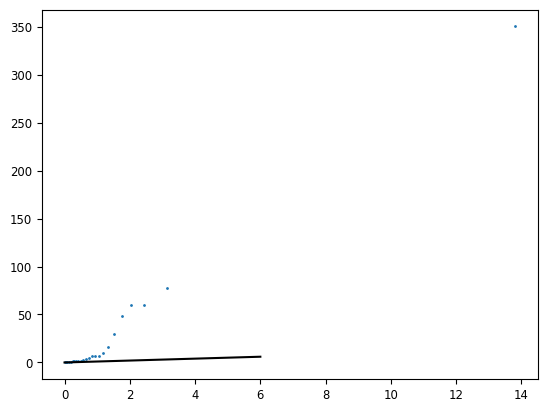

In [50]:
draw_qq(regression_de_result_wls[regression_de_result_wls['coef'].abs() > 1])

In [53]:
regression_de_result_wls[regression_de_result_wls['coef'].abs() > 1]

,coef,se,z,pval
feature_id,,,,
ENSG00000008130,1.225295,0.186643,1.207089,2.273978e-01
ENSG00000021355,-1.010283,0.124490,0.082604,9.341661e-01
ENSG00000023191,-1.297824,0.245135,1.214937,2.243902e-01
ENSG00000025708,-1.721119,0.178964,4.029416,5.591559e-05
ENSG00000026025,-1.051202,0.064927,0.788602,4.303446e-01
ENSG00000046651,2.185643,0.096848,12.242373,1.845559e-34
ENSG00000054277,1.230965,0.129242,1.787073,7.392571e-02
ENSG00000067225,-1.227040,0.110133,2.061501,3.925527e-02
ENSG00000070081,2.224711,0.114116,10.732150,7.190316e-27


<Axes: >

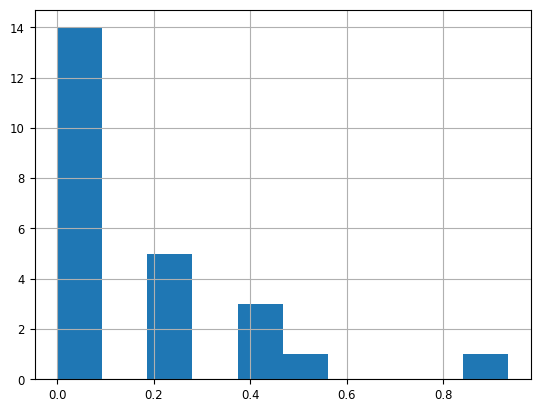

In [52]:
regression_de_result_wls[regression_de_result_wls['coef'].abs() > 1]['pval'].hist()

In [32]:
regression_de_result_wls['pval'].min()

0.0

In [10]:
X.shape

(680, 728)

In [11]:
regression_de_result_wls.shape

(300, 4)

In [ ]:
donor = '1004'

In [13]:
donor_mean = mean[mean.index.str.contains(donor)].sort_index()

NameError: name 'donor' is not defined

In [14]:
donor_list = estimators.donor_id.drop_duplicates()

In [15]:
all_estimators.query('donor_id == "1763" & feature_id == "ENSG00000002330"')

,cell_type,dataset_id,feature_id,assay,suspension_type,donor_id,disease,sex,nnz,n_obs,min,max,sum,mean,sem,treatment
1641186,conventional dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,ENSG00000002330,10x 3' v2,cell,1763,systemic lupus erythematosus,female,8.0,18203.0,1.0,1.0,8.0,9.591638e-08,3.680239e-08,cdc
4588890,plasmacytoid dendritic cell,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,ENSG00000002330,10x 3' v2,cell,1763,systemic lupus erythematosus,female,5.0,5233.0,1.0,2.0,6.0,2.942933e-07,1.484096e-07,pdc


In [16]:
donor_mean_centers = []
for donor in donor_list:
    donor_mean = mean[mean.index.str.contains(donor)].sort_index()
    if donor_mean.shape[0] < 2:
        continue
    donor_mean_centers.append( (donor, np.nanmean(np.log(donor_mean.iloc[1, :]/donor_mean.iloc[0, :]))))
donor_mean_centers = pd.DataFrame(donor_mean_centers, columns=['donor', 'center'])

<Axes: >

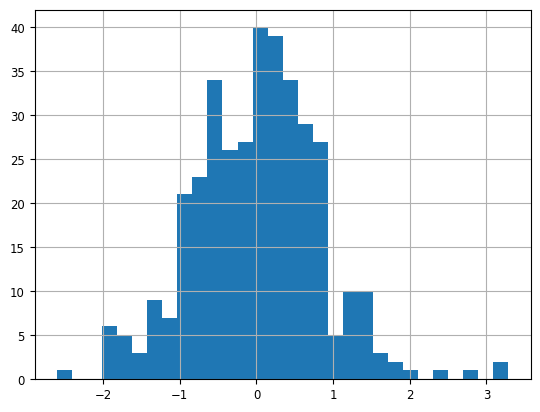

In [17]:
donor_mean_centers.sort_values('center').center.hist(bins=30)

In [18]:
donor_mean_centers.sort_values('center').tail(10)

,donor,center
326,CV0160,1.592757
306,IGTB1819,1.663976
172,C-8912,1.703512
66,HC-580,1.782013
343,CV0120,1.811110
177,C-8910,2.087592
182,C-8902,2.450011
178,C-8931,2.772693
364,CV0094,3.163429
315,AP1,3.282542


In [20]:
np.mean(donor_mean_centers.center)

0.014873071777733785

In [37]:
np.nanmean(np.log(donor_mean.iloc[1, :]/donor_mean.iloc[0, :]))

0.02290255865509656

<Axes: >

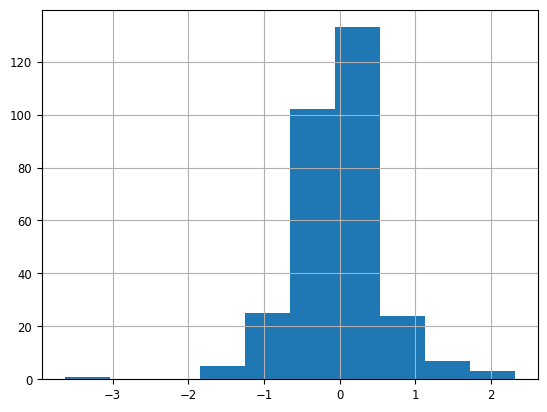

In [46]:
regression_de_result_wls['coef'].hist()

<Axes: xlabel='coef', ylabel='Density'>

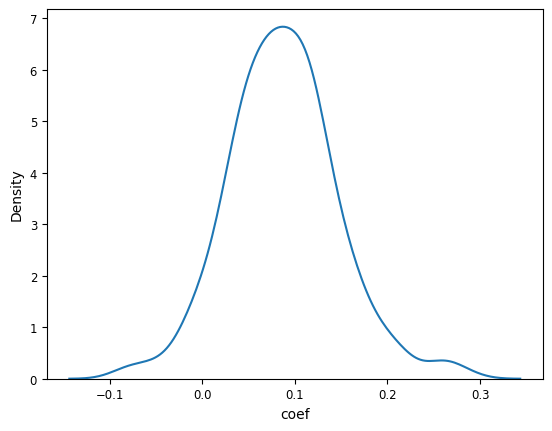

In [23]:
sns.kdeplot(regression_de_result_wls['coef'])

In [19]:
regression_de_result_wls

,coef,se,z,pval
feature_id,,,,
ENSG00000000419,0.083848,0.116763,0.718103,0.472694
ENSG00000000938,0.057297,0.068988,0.830543,0.406232
ENSG00000001036,0.117353,0.424327,0.276563,0.782116
ENSG00000002330,0.031638,0.140905,0.224535,0.822341
ENSG00000002549,0.063782,0.073257,0.870654,0.383943
...,...,...,...,...
ENSG00000271605,0.129875,0.164984,0.787197,0.431167
ENSG00000271614,0.091422,0.089476,1.021742,0.306903
ENSG00000272047,0.106062,0.100643,1.053835,0.291958


<Axes: >

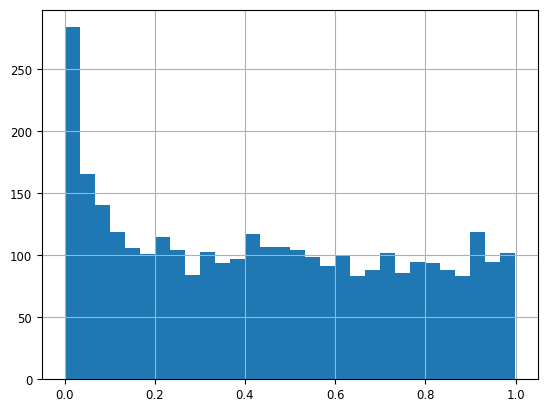

In [18]:
regression_de_result_wls['pval'].hist(bins=30)

(array([  1.,   0.,   3.,   3.,   2.,  12.,  29.,  40.,  58.,  92., 128.,
        124., 143., 140., 202., 138., 131., 235., 193., 183.,  33., 174.,
        199.,   0.,  31.,   5.,   5.,   3.,   2.,   1.]),
 array([-3.22642982, -3.01278474, -2.79913967, -2.5854946 , -2.37184953,
        -2.15820445, -1.94455938, -1.73091431, -1.51726924, -1.30362416,
        -1.08997909, -0.87633402, -0.66268895, -0.44904387, -0.2353988 ,
        -0.02175373,  0.19189134,  0.40553642,  0.61918149,  0.83282656,
         1.04647163,  1.26011671,  1.47376178,  1.68740685,  1.90105192,
         2.114697  ,  2.32834207,  2.54198714,  2.75563221,  2.96927729,
         3.18292236]),
 <BarContainer object of 30 artists>)

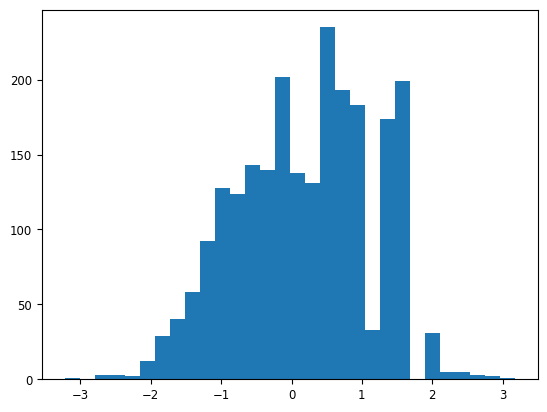

In [29]:
plt.hist(regression_de_result_wls['coef'], bins=30)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
result = meta_regression(y, v, sample_design[['treatment']].values, add_intercept=True, method='REML')
print(result.get_fe_stats()['z'])

In [ ]:
wls(X, y, n, v)

In [ ]:
data = sample_design.copy()
data['expr'] = y

In [ ]:
sns.stripplot(x='treatment', y='expr', data=data)

In [ ]:
feature

In [ ]:
md = smf.mixedlm("expr ~ treatment + dataset_id", data, groups=data['donor_id'])
mdf = md.fit()
mdf.summary()

In [ ]:
mdf.summary()

In [ ]:
data = 

In [ ]:
smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])

In [ ]:
regression_de_result_wls

In [ ]:
regression_de_result_wls['pval'].hist()

In [ ]:
from pymare import meta_regression


In [ ]:
result = meta_regression(y, v, sample_design[['treatment']].values, add_intercept=True, method='dl')

In [ ]:
result.get_fe_stats()

In [ ]:
dir(result)

In [ ]:
result.to_df()

In [ ]:
sample_design[['treatment']]

### Read rare ct comparison results

In [335]:
def draw_qq(df_input, thresh=1000, color='gray'):
    
    df = df_input[df_input[f'pval'] != 1.00].copy()
    df = (df[df[f'coef'].abs() < thresh])
    pvals = df[f'pval'].sort_values().values
    pvals = pvals[np.isfinite(pvals)]
    unif = np.linspace(1e-6, 1, len(pvals))
    # plt.scatter(unif, pvals, s=1)
    plt.scatter(-np.log10(unif), -np.log10(pvals), s=(3 if color=='cyan' else 1), color=color)
    # plt.plot(-np.log10(unif), -np.log10(unif), color='k')



In [336]:
result_fnames = ['rare_ct_whole.csv'] + [f'rare_ct_{d_id}.csv' for d_id in relevant_datasets]
names = ['whole'] + relevant_datasets

In [337]:
all_results = []
common_genes = set()
for name, fname in zip(names, result_fnames):
    
    res = pd.read_csv(save_path + fname).dropna()
    if res.shape[0] == 0:
        continue
    res = res.set_index('feature_id')
    if name == 'whole':
        common_genes = set(res.index)
    else:
        common_genes = common_genes & set(res.index)
    res['dataset'] = name
    all_results.append(res)
    # plt.ylim(-1, 10)
all_results = pd.concat(all_results).dropna().loc[list(common_genes)]

Text(0, 0.5, 'Observed\n-log10(P-value)')

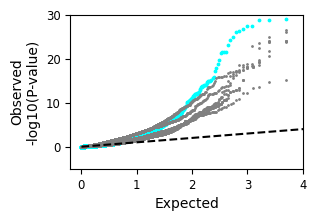

In [338]:
plt.figure(figsize=(3,2))
for name in names:

    draw_qq(all_results.query(f'dataset == "{name}" & pval > 1e-31'), color='cyan' if name == 'whole' else 'gray')


# draw_qq(all_results.query('dataset == "d1"'))
# draw_qq(all_results.query('dataset == "d2"'))
# draw_qq(all_results.query('dataset == "d3"'))
plt.ylim(-5, 30)
plt.xlim(-0.2, 4)
plt.plot([0,8], [0, 8],'--', color='k', );
plt.xlabel('Expected'); plt.ylabel('Observed\n-log10(P-value)')

In [125]:
all_results

,coef,se,z,pval,dataset
feature_id,,,,,
ENSG00000000419,-0.251705,0.166104,1.515342,1.296857e-01,whole
ENSG00000000457,1.554262,0.364091,4.268884,1.964533e-05,whole
ENSG00000000938,-2.361452,0.270333,8.735336,2.429334e-18,whole
ENSG00000001036,-0.897049,0.290389,3.089125,2.007472e-03,whole
ENSG00000001084,0.093108,0.272019,0.342286,7.321360e-01,whole
...,...,...,...,...,...
ENSG00000284968,0.583517,1.136739,0.513325,6.077241e-01,d3
ENSG00000285043,-0.265193,0.469652,0.564657,5.723068e-01,d3
ENSG00000285079,4.463383,2.735666,1.631552,1.027738e-01,d3


In [119]:
marker_genes = """TCF4: ENSG00000196628
BCL11A: ENSG00000119866
LY6D: ENSG00000167656
ID2: ENSG00000115738
BDCA2: ENSG00000198178
BDCA4: ENSG00000099250
IL3R: ENSG00000292332
RAG1: ENSG00000166349
EBF1: ENSG00000164330
RAG2: ENSG00000175097""".split('\n')
marker_genes = {x.split(': ')[0]:x.split(': ')[1] for x in marker_genes} 

In [120]:
marker_genes.values()

dict_values(['ENSG00000196628', 'ENSG00000119866', 'ENSG00000167656', 'ENSG00000115738', 'ENSG00000198178', 'ENSG00000099250', 'ENSG00000292332', 'ENSG00000166349', 'ENSG00000164330', 'ENSG00000175097'])

In [128]:
nonsig = all_results.query('dataset == "d2" & pval > 0.05 ')

In [141]:
subset = nonsig.join(all_results.query('dataset == "whole" & pval < 0.0001'), lsuffix='d2', rsuffix='whole', how='inner')\
    .sort_values('pvalwhole')

In [142]:
subset

,coefd2,sed2,zd2,pvald2,datasetd2,coefwhole,sewhole,zwhole,pvalwhole,datasetwhole
feature_id,,,,,,,,,,
ENSG00000105640,-0.028631,0.021354,1.340769,0.179996,d2,-0.174181,0.029189,5.967291,2.412257e-09,whole
ENSG00000116489,-0.094051,0.050610,1.858370,0.063116,d2,-0.233530,0.040290,5.796210,6.783020e-09,whole
ENSG00000019582,0.021448,0.021677,0.989440,0.322448,d2,-0.163312,0.029255,5.582306,2.373499e-08,whole
ENSG00000110077,0.012616,0.033302,0.378829,0.704815,d2,-0.163474,0.030317,5.392238,6.958560e-08,whole
ENSG00000241468,-0.019301,0.027785,0.694652,0.487273,d2,-0.155060,0.032677,4.745202,2.082983e-06,whole
ENSG00000143537,-0.962804,0.534343,1.801848,0.071569,d2,-1.521809,0.334574,4.548495,5.403104e-06,whole
ENSG00000112149,-0.500342,0.265604,1.883790,0.059593,d2,-0.869869,0.198566,4.380753,1.182699e-05,whole
ENSG00000205352,-0.041074,0.034992,1.173791,0.240479,d2,-0.156228,0.036380,4.294353,1.752039e-05,whole
ENSG00000227039,-0.761968,0.464616,1.639996,0.101006,d2,-1.373975,0.321085,4.279161,1.875992e-05,whole


In [127]:
all_results.loc[list(set(marker_genes.values()) & set(all_results.index))]

,coef,se,z,pval,dataset
feature_id,,,,,
ENSG00000196628,3.411365,0.062140,54.898373,0.000000e+00,whole
ENSG00000196628,3.392549,0.204209,16.613151,5.597385e-62,d1
ENSG00000196628,3.540395,0.075303,47.015519,0.000000e+00,d2
ENSG00000196628,3.023588,0.115605,26.154581,8.741098e-151,d3
ENSG00000099250,3.134274,0.529375,5.920702,3.205693e-09,whole
ENSG00000099250,3.580700,0.901553,3.971704,7.136038e-05,d1
ENSG00000099250,3.093041,0.714356,4.329833,1.492225e-05,d2
ENSG00000099250,3.120265,0.885519,3.523655,4.256386e-04,d3
ENSG00000115738,-2.217410,0.106235,20.872598,9.502663e-97,whole


In [ ]:
df_1.loc['ENSG00000075624']

In [ ]:
df_whole.loc[list(set(marker_genes.values()) & set(df_whole.index))]

In [ ]:
pvals = df['pval'].sort_values().values
pvals = pvals[np.isfinite(pvals)]
unif = np.linspace(1e-6, 1, len(pvals))
plt.scatter(-np.log(unif), -np.log(pvals))
plt.plot(-np.log10(unif), -np.log10(unif))

In [ ]:
plt.hist(pvals)

In [ ]:
draw_qq(df[df['coef'].abs() < 0.1], 'logp')

In [ ]:

df[df['z'].abs() > 0]['pval'].hist(bins=30)

In [ ]:
draw_qq(df_whole)

In [ ]:
pvals

In [ ]:
df_whole = pd.read_csv(save_path + 'rare_ct_whole.csv').set_index('feature_id')

In [ ]:
df_part.join(df_whole, lsuffix='_part', rsuffix='_whole').dropna().query('pval_part < 1.0')

In [ ]:
df[df['z'].abs() > 0]['pval']

In [ ]:
df_part[df_part['z'].abs() > 0]['pval'].hist(bins=20)

In [ ]:
def compare_dcs(all_estimators):
    
    def treatment_assignment(row):

        ct = row['cell_type']
        if 'plasma' in ct:
            return 'pdc'
        if 'conven' in ct or 'myeloid' in ct:
            return 'cdc'
        else:
            return 'unknown'

    all_estimators['treatment'] = all_estimators.apply(treatment_assignment, axis=1)
    estimators = all_estimators.query('treatment != "unknown"').copy()

    donors_to_use = estimators[['cell_type', 'donor_id']].drop_duplicates().groupby('donor_id').size()
    donors_to_use = donors_to_use[donors_to_use > 1].index.tolist()
    estimators = estimators.query('donor_id in @donors_to_use').copy()



    CUBE_TILEDB_DIMS_OBS = [
        "cell_type",
        "dataset_id",
    ]

    CUBE_TILEDB_ATTRS_OBS = [
        "assay",
        "suspension_type",
        "donor_id",
        "disease",
        "sex"
    ]

    CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

    DE_TREATMENT = 'treatment'
    DE_COVARIATES = ['donor_id']
    DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

    names = estimators[DE_TREATMENT].copy()
    for col in DE_COVARIATES:
        names += '_' + estimators[col]
    estimators['group_name'] = names.tolist()

    estimators = estimators.drop_duplicates(subset=['group_name', 'feature_id'])

    features = estimators['feature_id'].drop_duplicates().tolist()

    # This line doesnt do anything for actual run, just for shuffled
    groups = estimators.drop_duplicates(subset='group_name').set_index('group_name')

    mean = estimators.pivot(index='group_name', columns='feature_id', values='mean')
    se_mean = estimators.pivot(index='group_name', columns='feature_id', values='sem')
    cell_counts = groups['n_obs'].sort_index().values

    # Filter genes for actually expressed ones
    genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.6]
    mean = mean[genes_to_test]
    se_mean = se_mean[genes_to_test]

    # design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

    design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True, columns=['treatment'])
    design['constant'] = 1
    
    print(len(genes_to_test))

    # meta = 

    def get_final_design_matrix(design):
        cov_df = design.iloc[:, 1:]
        cov_df -= cov_df.mean(axis=0)
        stim_df = design.iloc[:, [0]]
        interaction_df = cov_df*stim_df[['treatment_pdc']].values
        interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
        cov_df = pd.concat([cov_df, interaction_df], axis=1)
        cov_df = sm.add_constant(cov_df)
        return  pd.concat([stim_df, cov_df], axis=1).values.astype(float)


    def wls(X, y, n, v, tau2=0, thresh=1):

        from sklearn.linear_model import LinearRegression

        # fit WLS using sample_weights
        WLS = LinearRegression(fit_intercept=False)
        WLS.fit(X, y, sample_weight=n)
        sample_err = ((WLS.predict(X) - y)**2).mean()

        coef = WLS.coef_[0]

        W = np.diag(1/ (v+tau2) )
        beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
        se = np.sqrt( beta_var_hat[0] )

        z = coef/se
        pv = stats.norm.sf(np.abs(z))

        return coef, z, pv

    # def resample_donors(X, y, n, v):

    from sklearn.linear_model import LinearRegression

    # %%time
    de_result = []
    for feature in genes_to_test[:2000]: # Can be vectorized heavily, showing for 1K genes

        m = mean[feature].values
        sem = se_mean[feature].values

        # Transform to log space (alternatively can resample in log space)
        lm = np.log(m)
        selm = (np.log(m+sem)-np.log(m-sem))/2

        sample_idxs = np.isfinite(m) & np.isfinite(sem)

        sample_design = design[['treatment_pdc', 'donor_id']].iloc[sample_idxs]

        donors_to_use_ = sample_design.groupby('donor_id').size()
        donors_to_use_ = donors_to_use_[donors_to_use_ > 1].index.tolist()

        final_sample_idxs = sample_design['donor_id'].isin(donors_to_use_).values

        # final_sample_idxs = np.ones(final_sample_idxs.shape[0]).astype(bool)


        X, y, n, v = (
            get_final_design_matrix(pd.get_dummies(sample_design.iloc[final_sample_idxs], columns=['donor_id'], drop_first=True)), 
            lm[sample_idxs][final_sample_idxs], 
            cell_counts[sample_idxs][final_sample_idxs], 
            selm[sample_idxs][final_sample_idxs]**2)
        
        
        if X.shape[0] != X.shape[1]:
            continue

        coef, z, pv = wls(X, y, n, v)

        de_result.append((feature, coef, z, pv))

    de_result_wls = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')
    
    return de_result_wls

### Grab cell counts

In [ ]:
import concurrent
import gc
import logging
import multiprocessing
import os
import sys
from concurrent import futures
import time

import numpy as np
import pandas as pd
import pyarrow as pa
import scipy.sparse
import scipy.sparse
import tiledb
import tiledbsoma as soma
from somacore import ExperimentAxisQuery, AxisQuery
from tiledb import ZstdFilter, ArraySchema, Domain, Dim, Attr, FilterList

In [ ]:
dataset_ids_to_query = ['c7775e88-49bf-4ba2-a03b-93f00447c958', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '4c4cd77c-8fee-4836-9145-16562a8782fe']
dataset_query = '('
for idx, di in enumerate(dataset_ids_to_query): 
    dataset_query += f'dataset_id == "{di}" '
    if idx != len(dataset_ids_to_query)-1:
        dataset_query += 'or '
dataset_query += ')'

celltypes_to_query = [
    'conventional dendritic cell',
    'plasmacytoid dendritic cell',
    'conventional dendritic cell',
    'plasmacytoid dendritic cell, human',
    'dendritic cell',
    'dendritic cell, human',
    'myeloid dendritic cell',
    'plasmacytoid dendritic cell']
celltype_query = '('
for idx, ct in enumerate(celltypes_to_query): 
    celltype_query += f'cell_type == "{ct}" '
    if idx != len(celltypes_to_query)-1:
        celltype_query += 'or '
celltype_query += ')'

OBS_VALUE_FILTER_1 = dataset_query # All cells in three datasets
OBS_VALUE_FILTER_2 = celltype_query + ' and ' + celltype_query # only relevant celltypes

In [ ]:
# init multiprocessing
start = time.time()
if multiprocessing.get_start_method(True) != "spawn":
    multiprocessing.set_start_method("spawn", True)

exp_uri = 's3://cellxgene-data-public/cell-census/2023-10-30/soma/census_data/homo_sapiens'
layer = "raw"
measurement_name = "RNA"

with soma.Experiment.open(uri=exp_uri,
                          context=soma.SOMATileDBContext().replace(tiledb_config={
                              "vfs.s3.region":"us-west-2",
                              "vfs.s3.no_sign_request":True})
                          ) as exp:

    query = exp.axis_query(measurement_name=measurement_name,
                           obs_query=AxisQuery(value_filter=OBS_VALUE_FILTER_2),
                           # Note: Must use *all* genes to compute size factors correctly, even when var filter is
                           # being used for testing
                           var_query=AxisQuery())

In [ ]:
TEST_MODE = bool(os.getenv("TEST_MODE", False))  # Read data from simple test fixture Census data
PROFILE_MODE = bool(os.getenv("PROFILE_MODE", False))  # Run pass 2 in single-process mode with profiling output

ESTIMATORS_CUBE_ARRAY_URI = "estimators_cube"

OBS_WITH_SIZE_FACTOR_TILEDB_ARRAY_URI = "obs_with_size_factor"

TILEDB_SOMA_BUFFER_BYTES = 2**31
if TEST_MODE:
    TILEDB_SOMA_BUFFER_BYTES = 10 * 1024 ** 2

# The minimum number of cells that should be processed at a time by each child process.
MIN_BATCH_SIZE = 2**14
# For testing
MIN_BATCH_SIZE = 20000

CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

if TEST_MODE:
    CUBE_TILEDB_DIMS_OBS = ["celltype"]
    CUBE_TILEDB_ATTRS_OBS = ["study"]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

CUBE_DIMS_VAR = ['feature_id']

if TEST_MODE:
    CUBE_DIMS_VAR = ['var_id']

CUBE_TILEDB_DIMS = CUBE_DIMS_VAR + CUBE_TILEDB_DIMS_OBS

ESTIMATOR_NAMES = ['nnz', 'n_obs', 'min', 'max', 'sum', 'mean', 'sem', 'var', 'sev', 'selv']


CUBE_SCHEMA = ArraySchema(
  domain=Domain(*[
    Dim(name=dim_name, dtype="ascii", filters=FilterList([ZstdFilter(level=-1), ]))
    for dim_name in CUBE_TILEDB_DIMS
  ]),
  attrs=[Attr(name=attr_name, dtype='ascii', nullable=False, filters=FilterList([ZstdFilter(level=-1), ]))
         for attr_name in CUBE_TILEDB_ATTRS_OBS] +
        [Attr(name=estimator_name, dtype='float64', var=False, nullable=False, filters=FilterList([ZstdFilter(level=-1), ]))
         for estimator_name in ESTIMATOR_NAMES],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=True,
  allows_duplicates=True,
)


In [ ]:
obs_df = query.obs().concat().to_pandas()

In [ ]:
obs_df.head(5)

In [ ]:
donor_counts = dict(obs_df.groupby('donor_id').size())

### Using 3 datasets

In [ ]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/results/'

In [ ]:
all_estimators = tiledb.open(cube_path + 'estimators_cube_dcs').df[:]\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})

In [ ]:
three_dataset_result = compare_dcs(all_estimators)

In [ ]:
three_dataset_result.to_csv(save_path + 'three_datasets.csv')

### Using 1 datasets

In [ ]:
dataset_ids_to_query = ['c7775e88-49bf-4ba2-a03b-93f00447c958', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '4c4cd77c-8fee-4836-9145-16562a8782fe']


In [ ]:
all_estimators = tiledb.open(cube_path + 'estimators_cube_dcs').df[:]\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})

In [ ]:
for dataset in dataset_ids_to_query:
    
    dataset_estimators = all_estimators.query(f'dataset_id == "{dataset}"')
    
    dataset_result = compare_dcs(dataset_estimators)
    break
    
    dataset_result.to_csv(save_path + f'{dataset}.csv')

In [ ]:
filtered=dataset_result.query('coef > 1 | coef < -1')

In [ ]:
pv = filtered['pval'].values
pv = np.sort(pv)

In [ ]:
ref = np.linspace(0, 1, pv.shape[0])

In [ ]:
plt.scatter(-np.log10(ref), -np.log10(pv))
plt.plot([0, 20], [0, 20])

### Randomly shuffled dataset (not0

In [ ]:
all_shuffled_estimators.query('dataset_id == "c7775e88-49bf-4ba2-a03b-93f00447c958"')

In [ ]:
all_shuffled_estimators = tiledb.open(cube_path + 'estimators_cube_dcs').df[:]\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})

In [ ]:
# shuffled_dataset_result = compare_dcs(all_shuffled_estimators)

In [ ]:
def treatment_assignment(row):

    ct = row['cell_type']
    if 'plasma' in ct:
        return 'pdc'
    if 'conven' in ct or 'myeloid' in ct:
        return 'cdc'
    else:
        return 'unknown'

all_shuffled_estimators['treatment'] = all_shuffled_estimators.apply(treatment_assignment, axis=1)
estimators = all_shuffled_estimators.query('treatment != "unknown"').copy()

donors_to_use = estimators[['cell_type', 'donor_id']].drop_duplicates().groupby('donor_id').size()
donors_to_use = donors_to_use[donors_to_use > 1].index.tolist()
estimators = estimators.query('donor_id in @donors_to_use').copy()



CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

DE_TREATMENT = 'treatment'
DE_COVARIATES = ['donor_id']
DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

names = estimators[DE_TREATMENT].copy()
for col in DE_COVARIATES:
    names += '_' + estimators[col]
estimators['group_name'] = names.tolist()

estimators = estimators.drop_duplicates(subset=['group_name', 'feature_id'])

features = estimators['feature_id'].drop_duplicates().tolist()

# This line doesnt do anything for actual run, just for shuffled
groups = estimators.drop_duplicates(subset='group_name').set_index('group_name')

# mean = estimators.pivot(index='group_name', columns='feature_id', values='mean')
# se_mean = estimators.pivot(index='group_name', columns='feature_id', values='sem')
# cell_counts = groups['n_obs'].sort_index().values

# # Filter genes for actually expressed ones
# genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.6]
# mean = mean[genes_to_test]
# se_mean = se_mean[genes_to_test]

# # design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

# design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True, columns=['treatment'])
# design['constant'] = 1

In [ ]:
# problematic '1031' '1022',
# good '1004', '1014' '1015', '1019', '1039'

In [ ]:

one_donor_estimators = estimators#.query(f'donor_id in @donor_to_check')

groups = one_donor_estimators.drop_duplicates(subset='group_name').set_index('group_name')


In [ ]:
mean = one_donor_estimators.pivot(index='group_name', columns='feature_id', values='mean')
se_mean = one_donor_estimators.pivot(index='group_name', columns='feature_id', values='sem')
cell_counts = groups['n_obs'].sort_index().values

# Filter genes for actually expressed ones
genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.7]
mean = mean[genes_to_test]
se_mean = se_mean[genes_to_test]

In [ ]:
# design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

LFC_THRESHOLD = 0.5


design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True, columns=['treatment'])
design['constant'] = 1

print(len(genes_to_test))

# meta = 

def get_final_design_matrix(design):
    cov_df = design.iloc[:, 1:]
    cov_df -= cov_df.mean(axis=0)
    stim_df = design.iloc[:, [0]]
    interaction_df = cov_df*stim_df[['treatment_pdc']].values
    interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
    cov_df = pd.concat([cov_df, interaction_df], axis=1)
    cov_df = sm.add_constant(cov_df)
    return  pd.concat([stim_df, cov_df], axis=1).values.astype(float)


def wls(X, y, n, v, tau2=0, thresh=1):

    from sklearn.linear_model import LinearRegression
    
    # fit WLS using sample_weights
    WLS = LinearRegression(fit_intercept=False)
    WLS.fit(X, y)
    sample_err = ((WLS.predict(X) - y)**2).mean()
    # print(WLS.coef_)

    coef = WLS.coef_[0]

    # W = np.diag(1/ (v) )
    W = 1/v
    try:
        beta_var_hat = np.diag(np.linalg.pinv((X.T *W)@X ))
    except:
        return coef, 0, 0
    # print(beta_var_hat)
    se = np.sqrt( beta_var_hat[0] )
    
    if np.abs(coef) < LFC_THRESHOLD:
        z = 0
        pv = 1
    else:
        z = (np.abs(coef)-LFC_THRESHOLD)/se
        pv = stats.norm.sf(np.abs(z))*2

    return coef, z, pv

# def resample_donors(X, y, n, v):

from sklearn.linear_model import LinearRegression

# %%time
regression_de_result = []
manual_de_result = []

for feature in genes_to_test: # Can be vectorized heavily, showing for 1K genes

    m = mean[feature].values
    sem = se_mean[feature].values

    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)

    sample_design = design[['treatment_pdc', 'donor_id']].iloc[sample_idxs]

    donors_to_use_ = sample_design.groupby('donor_id').size()
    donors_to_use_ = donors_to_use_[donors_to_use_ > 1].index.tolist()

    final_sample_idxs = sample_design['donor_id'].isin(donors_to_use_).values

    final_sample_idxs = np.ones(final_sample_idxs.shape[0]).astype(bool)


    X, y, n, v = (
        get_final_design_matrix(pd.get_dummies(sample_design.iloc[final_sample_idxs], columns=['donor_id'], drop_first=True)), 
        lm[sample_idxs][final_sample_idxs], 
        cell_counts[sample_idxs][final_sample_idxs], 
        selm[sample_idxs][final_sample_idxs]**2)

    
    # if X.shape[0] != X.shape[1]:
    #     continue

    coef1, z1, pv1 = wls(X, y, n, v)
    regression_de_result.append((feature, coef1, z1, pv1))


manual_de_result_wls = pd.DataFrame(manual_de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')
regression_de_result_wls = pd.DataFrame(regression_de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')

In [ ]:
regression_de_result_wls

In [ ]:
sns.kdeplot(regression_de_result_wls['coef'])

In [ ]:
regression_de_result_wls.query('z != 0')['pval'].hist(bins=10, density=True)

In [ ]:
_, manual_de_result_wls['fdr'] = fdrcorrection(manual_de_result_wls['pval'])

In [ ]:
manual_de_result_wls.query('fdr < 0.1').sort_values('fdr')

In [ ]:
mean

In [ ]:
(shuffled_dataset_result['pval']*2).hist()

In [ ]:
def treatment_assignment(row):
    
    ct = row['cell_type']
    if 'plasma' in ct:
        return 'pdc'
    if 'conven' in ct or 'myeloid' in ct:
        return 'cdc'
    else:
        return 'unknown'

all_estimators['treatment'] = all_estimators.apply(treatment_assignment, axis=1)
estimators = all_estimators.query('treatment != "unknown"').copy()

donors_to_use = estimators[['cell_type', 'donor_id']].drop_duplicates().groupby('donor_id').size()
donors_to_use = donors_to_use[donors_to_use > 1].index.tolist()
estimators = estimators.query('donor_id in @donors_to_use').copy()



CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

DE_TREATMENT = 'treatment'
DE_COVARIATES = ['donor_id']
DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

names = estimators[DE_TREATMENT].copy()
for col in DE_COVARIATES:
    names += '_' + estimators[col]
estimators['group_name'] = names.tolist()

estimators = estimators.drop_duplicates(subset=['group_name', 'feature_id'])

features = estimators['feature_id'].drop_duplicates().tolist()

mean = estimators.pivot(index='group_name', columns='feature_id', values='mean')
se_mean = estimators.pivot(index='group_name', columns='feature_id', values='sem')
cell_counts = groups['n_obs'].sort_index().values

# Filter genes for actually expressed ones
genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.6]
mean = mean[genes_to_test]
se_mean = se_mean[genes_to_test]

# design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True, columns=['treatment'])
design['constant'] = 1

# meta = 

def get_final_design_matrix(design):
    cov_df = design.iloc[:, 1:]
    cov_df -= cov_df.mean(axis=0)
    stim_df = design.iloc[:, [0]]
    interaction_df = cov_df*stim_df[['treatment_pdc']].values
    interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
    cov_df = pd.concat([cov_df, interaction_df], axis=1)
    cov_df = sm.add_constant(cov_df)
    return  pd.concat([stim_df, cov_df], axis=1).values.astype(float)
    

def wls(X, y, n, v, tau2=0):
    
    from sklearn.linear_model import LinearRegression
    
    # fit WLS using sample_weights
    WLS = LinearRegression(fit_intercept=False)
    WLS.fit(X, y, sample_weight=n)
    sample_err = ((WLS.predict(X) - y)**2).mean()

    coef = WLS.coef_[0]

    W = np.diag(1/ (v+tau2) )
    beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
    se = np.sqrt( beta_var_hat[0] )

    z = coef/se
    pv = stats.norm.sf(np.abs(z))*2
    
    return coef, z, pv

# def resample_donors(X, y, n, v):

from sklearn.linear_model import LinearRegression

# %%time
de_result = []
for feature in genes_to_test[:2000]: # Can be vectorized heavily, showing for 1K genes
    
    m = mean[feature].values
    sem = se_mean[feature].values
    
    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)
    
    sample_design = design[['treatment_pdc', 'donor_id']].iloc[sample_idxs]
    
    donors_to_use_ = sample_design.groupby('donor_id').size()
    donors_to_use_ = donors_to_use_[donors_to_use_ > 1].index.tolist()
    
    final_sample_idxs = sample_design['donor_id'].isin(donors_to_use_).values
    
    # final_sample_idxs = np.ones(final_sample_idxs.shape[0]).astype(bool)
    

    X, y, n, v = (
        get_final_design_matrix(pd.get_dummies(sample_design.iloc[final_sample_idxs], columns=['donor_id'], drop_first=True)), 
        lm[sample_idxs][final_sample_idxs], 
        cell_counts[sample_idxs][final_sample_idxs], 
        selm[sample_idxs][final_sample_idxs]**2)
    assert X.shape[0] == X.shape[1]

    coef, z, pv = wls(X, y, n, v)
    
    de_result.append((feature, coef, z, pv))

de_result_wls = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')
de_result_wls.to_csv(save_path + 'three_datasets.csv')

In [ ]:
_, de_result_wls['fdr'] = fdrcorrection(de_result_wls['pval'])

In [ ]:
de_result_wls['pval'].hist(density=True)

### Using 3 datasets

In [ ]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/results/'

In [ ]:
all_estimators = tiledb.open(cube_path + 'estimators_cube_2').df[:]\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})

In [ ]:
def treatment_assignment(row):
    
    ct = row['cell_type']
    if 'plasma' in ct:
        return 'pdc'
    if 'conven' in ct or 'myeloid' in ct:
        return 'cdc'
    else:
        return 'unknown'

In [ ]:
all_estimators['treatment'] = all_estimators.apply(treatment_assignment, axis=1)
estimators = all_estimators.query('treatment != "unknown"').copy()

In [ ]:
donors_to_use = estimators[['cell_type', 'donor_id']].drop_duplicates().groupby('donor_id').size()
donors_to_use = donors_to_use[donors_to_use > 1].index.tolist()
estimators = estimators.query('donor_id in @donors_to_use').copy()



In [ ]:
CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

DE_TREATMENT = 'treatment'
DE_COVARIATES = ['donor_id']
DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

In [ ]:
names = estimators[DE_TREATMENT].copy()
for col in DE_COVARIATES:
    names += '_' + estimators[col]
estimators['group_name'] = names.tolist()

estimators = estimators.drop_duplicates(subset=['group_name', 'feature_id'])

In [ ]:
features = estimators['feature_id'].drop_duplicates().tolist()

# This line doesnt do anything for actual run, just for shuffled
groups = estimators.drop_duplicates(subset='group_name').set_index('group_name')

In [ ]:
mean = estimators.pivot(index='group_name', columns='feature_id', values='mean')
se_mean = estimators.pivot(index='group_name', columns='feature_id', values='sem')
cell_counts = groups['n_obs'].sort_index().values

# Filter genes for actually expressed ones
genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.6]
mean = mean[genes_to_test]
se_mean = se_mean[genes_to_test]

In [ ]:
# design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True, columns=['treatment'])
design['constant'] = 1

# meta = 

### Run DE

In [ ]:
def get_final_design_matrix(design):
    cov_df = design.iloc[:, 1:]
    cov_df -= cov_df.mean(axis=0)
    stim_df = design.iloc[:, [0]]
    interaction_df = cov_df*stim_df[['treatment_pdc']].values
    interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
    cov_df = pd.concat([cov_df, interaction_df], axis=1)
    cov_df = sm.add_constant(cov_df)
    return  pd.concat([stim_df, cov_df], axis=1).values.astype(float)
    

In [ ]:
def wls(X, y, n, v, tau2=0):
    
    from sklearn.linear_model import LinearRegression
    
    # fit WLS using sample_weights
    WLS = LinearRegression(fit_intercept=False)
    WLS.fit(X, y, sample_weight=n)
    sample_err = ((WLS.predict(X) - y)**2).mean()

    coef = WLS.coef_[0]

    W = np.diag(1/ (v+tau2) )
    beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
    se = np.sqrt( beta_var_hat[0] )

    z = coef/se
    pv = stats.norm.sf(np.abs(z))*2
    
    return coef, z, pv

In [ ]:
# def resample_donors(X, y, n, v):

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# %%time
de_result = []
for feature in genes_to_test[:2000]: # Can be vectorized heavily, showing for 1K genes
    
    m = mean[feature].values
    sem = se_mean[feature].values
    
    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)
    
    sample_design = design[['treatment_pdc', 'donor_id']].iloc[sample_idxs]
    
    donors_to_use_ = sample_design.groupby('donor_id').size()
    donors_to_use_ = donors_to_use_[donors_to_use_ > 1].index.tolist()
    
    final_sample_idxs = sample_design['donor_id'].isin(donors_to_use_).values
    
    # final_sample_idxs = np.ones(final_sample_idxs.shape[0]).astype(bool)
    

    X, y, n, v = (
        get_final_design_matrix(pd.get_dummies(sample_design.iloc[final_sample_idxs], columns=['donor_id'], drop_first=True)), 
        lm[sample_idxs][final_sample_idxs], 
        cell_counts[sample_idxs][final_sample_idxs], 
        selm[sample_idxs][final_sample_idxs]**2)
    assert X.shape[0] == X.shape[1]

    coef, z, pv = wls(X, y, n, v)
    
    de_result.append((feature, coef, z, pv))

de_result_wls = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')
de_result_wls.to_csv(save_path + 'three_datasets.csv')

In [ ]:
_, de_result_wls['fdr'] = fdrcorrection(de_result_wls['pval'])

In [ ]:
de_result_wls['pval'].hist(density=True)

In [ ]:
%%time
de_result = []
for feature in genes_to_test[:3000]: # Can be vectorized heavily, showing for 1K genes
    
    m = mean[feature].values
    sem = se_mean[feature].values
    
    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)

    X, y, n, v = design.iloc[sample_idxs], lm[sample_idxs], cell_counts[sample_idxs], selm[sample_idxs]**2
    info = X.copy()
    info['y'] = y
    info['n'] = n
    info['v'] = v
    info.index = info['donor_id']
    
    donors = info['donor_id'].drop_duplicates().tolist()
    num_donors =len(donors)
    
    num_boot = 1000
    params = np.zeros(num_boot)
    for b in range(num_boot):
        boot_donors = np.random.choice(donors, num_donors, replace=True)
        info_b = info.loc[list(boot_donors)]
        info_b['y_b'] = stats.norm.rvs(info_b['y'], np.sqrt(info_b['v']))
        params[b] = LinearRegression(fit_intercept=False).fit(info_b[['treatment_pdc', 'constant']], info_b['y_b'], sample_weight=info_b['n']).coef_[0]
    
    coef = params.mean()
    se = params.std()
    z = coef/se
    pv = stats.norm.sf(np.abs(z))*2
    # coef, z, pv = de_wls(2)
    
    de_result.append((feature, coef, z, pv))
    
de_result_resampled = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')

In [ ]:
de_result_resampled.shape

In [ ]:
de_result_resampled['pval'].hist(density=True)

In [ ]:
%%time
de_result = []
for feature in genes_to_test[:1000]: # Can be vectorized heavily, showing for 1K genes
    
    m = mean[feature].values
    sem = se_mean[feature].values
    
    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)

    X, y, n, v = design.iloc[sample_idxs], lm[sample_idxs], cell_counts[sample_idxs], selm[sample_idxs]**2
    
    
    
    
    # coef, z, pv = de_wls(2)
    
    de_result.append((feature, coef, z, pv))
    
de_result_dsl = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')